In [1]:
# !pip install tensorflow numpy
# !pip install tensorboard

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

Tensorflow version:  2.12.0
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


# Fashion MNIST, MLP

(60000, 784) (60000, 10)


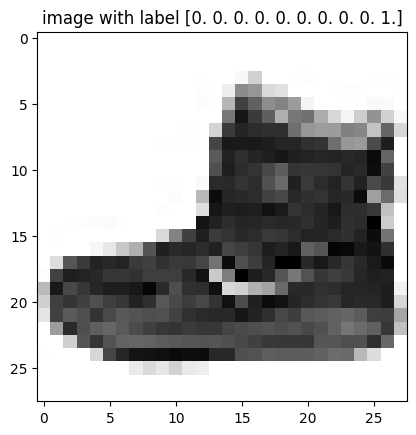

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

n, x, y = x_train.shape
# reshape data
x_train = x_train.reshape(n, x * y)
y_train = tf.keras.utils.to_categorical(y_train)

n, x, y = x_test.shape
# reshape data
x_test = x_test.reshape(n, x * y)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape, y_train.shape)
plt.figure()
plt.title(f"image with label {y_train[0]}")
plt.imshow(x_train[0].reshape(28, 28), cmap='Greys')
plt.show()

In [16]:
def build_mlp_model(input_shape, num_outputs, **kwargs):
    model: tf.keras.Model = tf.keras.Sequential()
    model.add(tf.keras.Input(input_shape))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(num_outputs, activation='softmax'))
    optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adadelta())
    loss = kwargs.get('loss', tf.keras.losses.categorical_crossentropy)
    metrics = kwargs.get('metrics', ['accuracy'])
    model.summary()
    model.compile(optimizer, loss, metrics)
    return model

MLP: tf.keras.Model = build_mlp_model(x_train.shape[1], y_train.shape[1])
MLP.fit(x_train, y_train, batch_size=128, epochs=20, validation_split = 0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               401920    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
375/375 [============================

In [17]:
score = MLP.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 7ms/step - loss: 6.0616 - accuracy: 0.7752
Test loss: 6.061596870422363
Test accuracy: 0.7752000093460083
